# 1. Import Dependencies

In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
import itertools
import warnings

# Ignoring warning messages for cleaner output
warnings.filterwarnings('ignore')

C:\Users\passz\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# 2. Load Data

In [2]:
# Downloading TSLA stock data
data = yf.download('BTC-USD', start="2015-01-01", end="2023-12-02")
df = data[['Open', 'High', 'Low', 'Close']]
df.head(10)

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close
Date,,,,
2015-01-01,320.434998,320.434998,314.002991,314.248993
2015-01-02,314.079010,315.838989,313.565002,315.032013
2015-01-03,314.846008,315.149994,281.082001,281.082001
2015-01-04,281.145996,287.230011,257.612000,264.195007
2015-01-05,265.084015,278.341003,265.084015,274.473999
2015-01-06,274.610992,287.553009,272.696014,286.188995
2015-01-07,286.076996,298.753998,283.079010,294.337006
2015-01-08,294.135010,294.135010,282.174988,283.348999
2015-01-09,282.382996,291.114014,280.532990,290.407990


# 3. Check Data Stationarity

In [3]:
# Checking the stationarity of the data
for column in df.columns:
    result = adfuller(df[column])
    print(f'ADF Statistic for {column}: {result[0]}')
    print(f'p-value for {column}: {result[1]}')
    for key, value in result[4].items():
        print(f'Critical Value for {column} ({key}): {value}')
    if result[1] <= 0.05:
        print(f'{column} is stationary\n')
    else:
        print(f'{column} is not stationary\n')

ADF Statistic for Open: -1.4224738722804433
p-value for Open: 0.5714557072673438
Critical Value for Open (1%): -3.432378047525015
Critical Value for Open (5%): -2.862436069383185
Critical Value for Open (10%): -2.5672469973560355
Open is not stationary

ADF Statistic for High: -1.4401026572679931
p-value for High: 0.562906666965696
Critical Value for High (1%): -3.4323767903784113
Critical Value for High (5%): -2.862435514116478
Critical Value for High (10%): -2.5672467017431932
High is not stationary

ADF Statistic for Low: -1.4798557338068874
p-value for Low: 0.5434518455441644
Critical Value for Low (1%): -3.4323774187568326
Critical Value for Low (5%): -2.8624357916637844
Critical Value for Low (10%): -2.5672468495037997
Low is not stationary

ADF Statistic for Close: -1.3947959637031977
p-value for Close: 0.5847684403741523
Critical Value for Close (1%): -3.432378047525015
Critical Value for Close (5%): -2.862436069383185
Critical Value for Close (10%): -2.5672469973560355
Close i

# 4. Seasonal Decomposition of Features

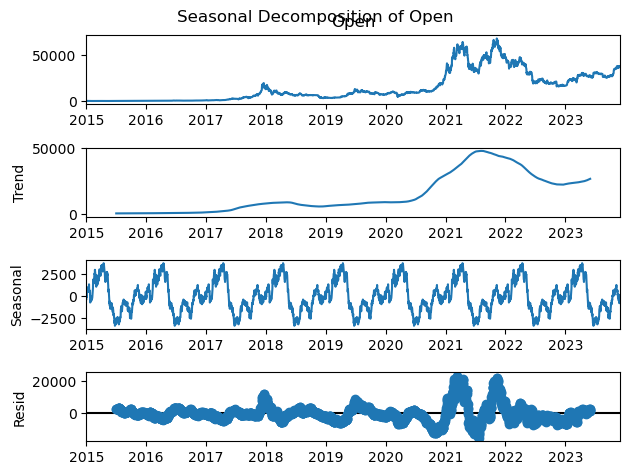

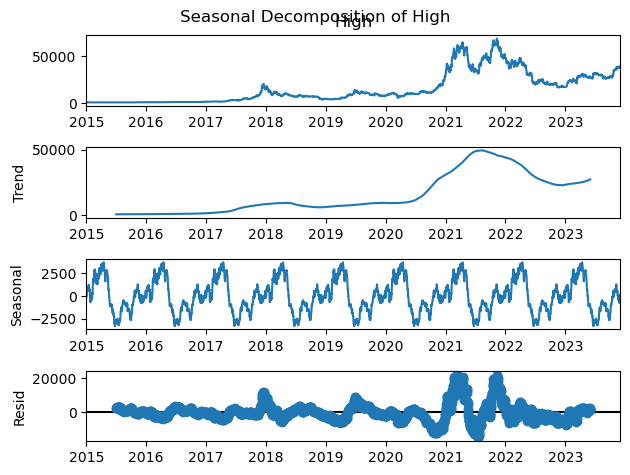

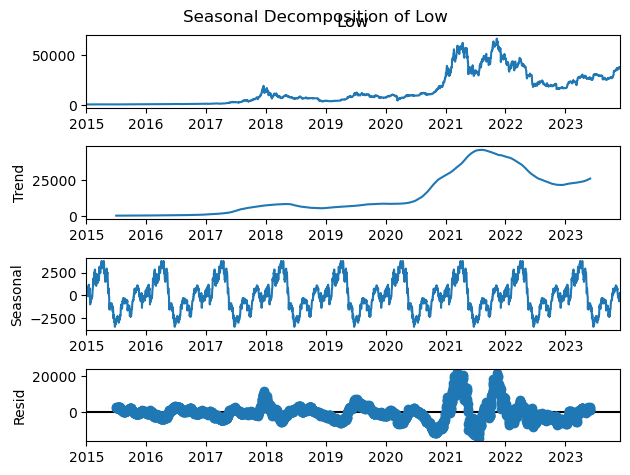

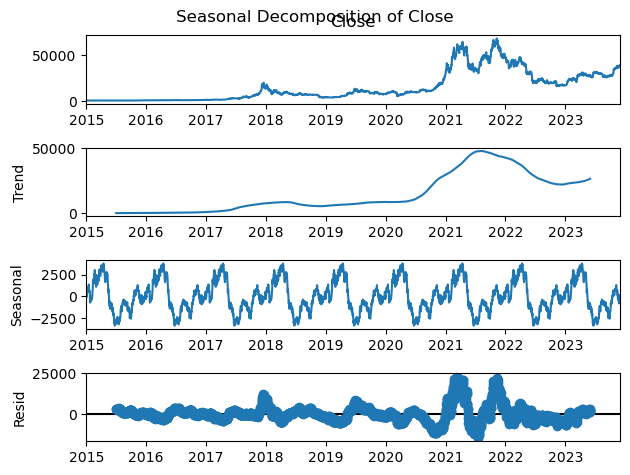

In [4]:
# Seasonal Decomposition of each series
for column in df.columns:
    result = seasonal_decompose(df[column], period=365) # Adjust the period according to your data's frequency
    result.plot()
    plt.suptitle(f'Seasonal Decomposition of {column}')
    plt.show()

# 5. ACF and PACF

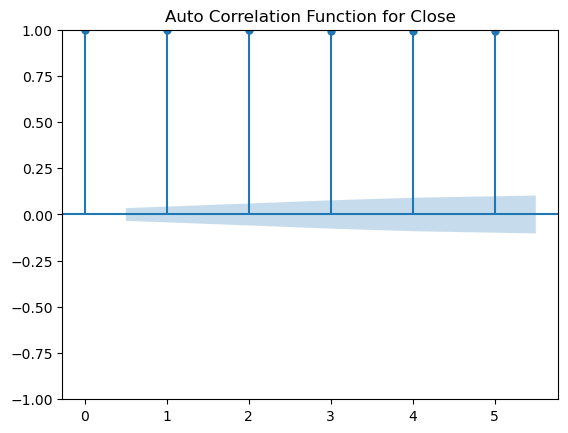

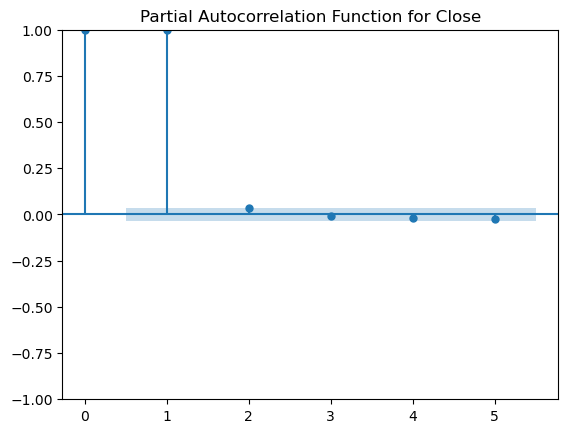

In [5]:
# Finding out the orders for p and q using ACF and PACF
lags = 5  # Adjust the number of lags according to your data's frequency

# Plotting ACF and PACF for 'Close' as an example
plot_acf(df['Close'], lags=lags, title='Auto Correlation Function for Close')
plot_pacf(df['Close'], lags=lags, title='Partial Autocorrelation Function for Close')
plt.show()

# 6. Hyperparameter Tuning (p,d,q)

In [9]:
# Define d as 1 since series becomes stationary after 1st differencing (based on above analysis)
d = 1

# Splitting the data into training and test sets (80-20 split)
split_point = int(len(df) * 0.8)
train = df.iloc[:split_point]
test = df.iloc[split_point:]

# Define exogenous features
exogenous_features = ['Open', 'High', 'Low']

# Fitting the ARIMA model (Using 'Close' as an example and arbitrary (p,d,q) values)
# Define the range of p and q to test
p = range(6, 11)  # Example range for AR terms
q = range(6, 11)  # Example range for MA terms

# Generate all different combinations of p, q triplets
pq_combinations = list(itertools.product(p, [d], q))

# Initialize an empty list to store results
results_list = []

for combination in pq_combinations:
    try:
        # Fit ARIMA model
        model = sm.tsa.arima.ARIMA(train['Close'], order=combination, exog=train[exogenous_features])
        model_fit = model.fit()
        
        # Make predictions on training set
        train['Predictions'] = model_fit.predict(start=0, end=len(train)-1, exog=train[exogenous_features])
        
        # Make predictions on test set
        forecast = [model_fit.forecast(exog=test[exogenous_features].iloc[i]).values[0] for i in range(len(test))]
        test['Forecast'] = forecast
        
        # Calculate RMSE
        rmse = np.sqrt(mean_squared_error(test['Close'], test['Forecast']))
        
        # Store results in the list
        results_list.append({'p': combination[0], 'd': combination[1], 'q': combination[2], 'RMSE': rmse})
    except Exception as e:
        print(f'Error with combination {combination}: {e}')

# Convert the list of results to a DataFrame
results = pd.DataFrame(results_list)

# Find the best performing set of parameters
best_params = results.loc[results['RMSE'].idxmin()]
print("Best ARIMA Parameters:")
print(best_params)

Best ARIMA Parameters:
p         9.000000
d         1.000000
q         7.000000
RMSE    312.432376
Name: 16, dtype: float64


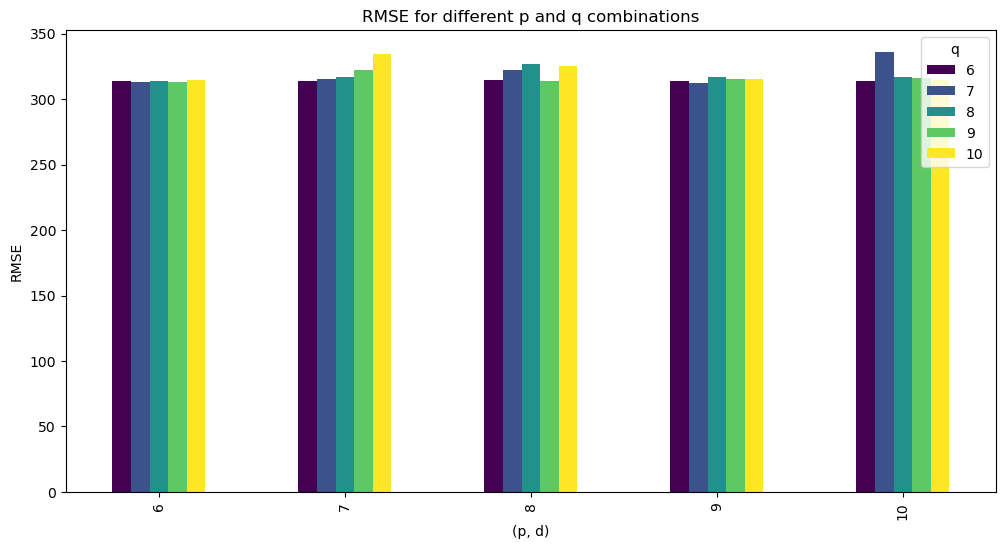

In [10]:
# Pivot the results DataFrame for plotting
pivot_results = results.pivot_table(index='p', columns='q', values='RMSE')

# Plot the RMSE for each parameter combination
pivot_results.plot(kind='bar', figsize=(12, 6), colormap='viridis')
plt.title('RMSE for different p and q combinations')
plt.xlabel('(p, d)')
plt.ylabel('RMSE')
plt.show()

# 7. Fit Model w/ Best Values

In [11]:
# Fit ARIMA model (using Close price)
p = 9
q = 7
d = 1

model = sm.tsa.arima.ARIMA(train['Close'], order=(p, d, q), exog=train[exogenous_features])
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2605
Model:                 ARIMA(9, 1, 7)   Log Likelihood              -18861.076
Date:                Sat, 02 Dec 2023   AIC                          37762.152
Time:                        23:12:17   BIC                          37879.448
Sample:                    01-01-2015   HQIC                         37804.648
                         - 02-17-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Open          -0.5597      0.009    -64.697      0.000      -0.577      -0.543
High           0.9156      0.008    107.766      0.000       0.899       0.932
Low            0.6394      0.005    118.152      0.0

# 8. Evaluate on Train/Test

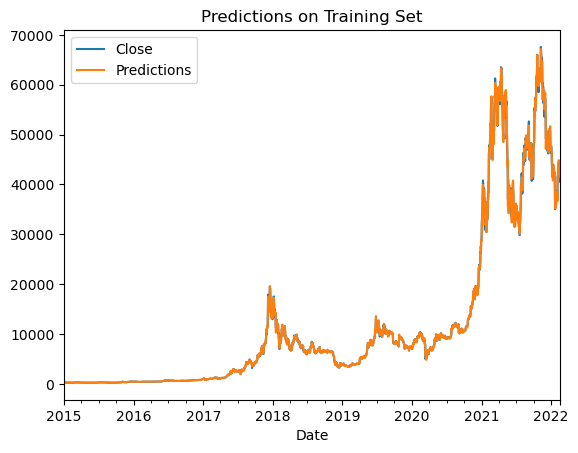

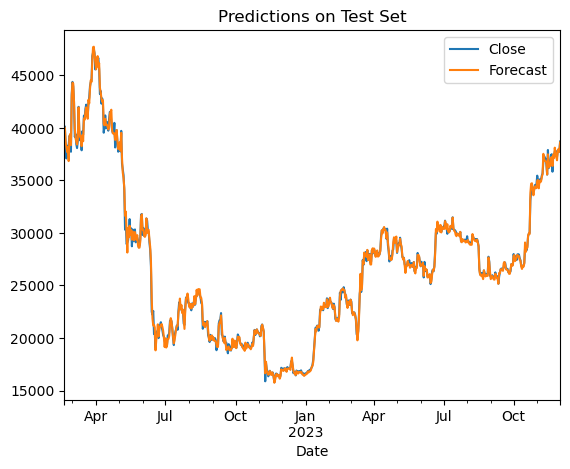

The RMSE for the ARIMA model is 312.4324


In [12]:
# Making Predictions on Training Set
train['Predictions'] = model_fit.predict(start=0, end=len(train)-1, exog=train[exogenous_features])
train[['Close', 'Predictions']].plot()
plt.title('Predictions on Training Set')
plt.show()

# Making Predictions on Test Set
forecast = [model_fit.forecast(exog=test[exogenous_features].iloc[i]).values[0] for i in range(len(test))]
test['Forecast'] = forecast
test[['Close', 'Forecast']].plot()
plt.title('Predictions on Test Set')
plt.show()

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['Close'], test['Forecast']))
print(f'The RMSE for the ARIMA model is {round(rmse, 4)}')

# 9. Strategy Implementation

In [29]:
# Initialize trading parameters
account_balance = 100000  # Starting balance
positions_open = 0
total_trades = 0
global_entry_price = 0
prev_forecast_price = 0
bitcoin_held = 0  # Amount of Bitcoin held
transaction_fee = 0.001  # Assuming a 0.1% transaction fee
trade_log = []

# Functino to calculate bollinger bands
def calculate_bollinger_bands(prices, window=20, num_std_dev=2):
    rolling_mean = prices.rolling(window=window).mean()
    rolling_std = prices.rolling(window=window).std()
    upper_band = rolling_mean + (rolling_std * num_std_dev)
    lower_band = rolling_mean - (rolling_std * num_std_dev)
    return upper_band, lower_band

def calculate_rsi(prices, window=14):
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_macd(prices, slow=26, fast=12, signal=9):
    exp1 = prices.ewm(span=fast, adjust=False).mean()
    exp2 = prices.ewm(span=slow, adjust=False).mean()
    macd = exp1 - exp2
    macd_signal = macd.ewm(span=signal, adjust=False).mean()
    return macd, macd_signal

# Function to handle trade entry
def enter_trade(current_price, forecast_price, timestamp, lower_band, account_balance, bitcoin_held, current_rsi, current_macd, current_macd_signal):
    global total_trades, trade_log, global_entry_price
    # Buying logic considering Bollinger Bands, RSI, MACD, and forecast
    if (forecast_price > prev_forecast_price and 
        current_price < lower_band and 
        current_rsi < 30 and 
        current_macd < current_macd_signal and 
        account_balance >= current_price):
        
        # Decide how much BTC to buy (e.g., a fixed fraction of the account balance)
        btc_amount = (account_balance * 0.1) / current_price  # Example: 10% of account balance
        account_balance -= btc_amount * current_price
        bitcoin_held += btc_amount
        global_entry_price = current_price

        trade_log.append({'timestamp': timestamp, 'action': 'buy', 'price': current_price, 'btc_amount': btc_amount, 'profit_loss': 0})
        total_trades += 1
        print(f"Buy {btc_amount} BTC at price {current_price}")
    return account_balance, bitcoin_held

# Function handle trade exit
def exit_trade(current_price, forecast_price, timestamp, upper_band, account_balance, bitcoin_held, current_rsi, current_macd, current_macd_signal):
    global total_trades, trade_log, global_entry_price
    # Check if there are any bitcoins to sell
    if bitcoin_held > 0:
        sell_amount = bitcoin_held * current_price
        profit_loss = sell_amount - (bitcoin_held * global_entry_price)  # Calculate profit or loss
        account_balance += sell_amount
        bitcoin_held = 0

        trade_log.append({'timestamp': timestamp, 'action': 'sell', 'price': current_price, 'btc_amount': bitcoin_held, 'profit_loss': profit_loss})
        total_trades += 1
        print(f"Sell at price {current_price}, Profit/Loss: {profit_loss}")

    return account_balance, bitcoin_held

# 10. Simulated Forward-Testing

Processing data for 2023-11-27
Buy 0.2669963364325529 BTC at price 37498.16
Buy 0.24028508203253873 BTC at price 37499.9735
Buy 0.21625213633231152 BTC at price 37500.743
Buy 0.19466096692992693 BTC at price 37494.1845
Buy 0.17538501474205762 BTC at price 37453.535
Buy 0.1577894068983061 BTC at price 37467.09
Buy 0.14247562994103483 BTC at price 37344.765
Buy 0.1283873239242739 BTC at price 37298.441
Buy 0.1155314345515861 BTC at price 37303.98
Buy 0.10415970929555568 BTC at price 37239.0065
Sell at price 37314.031, Profit/Loss: 130.68690519551456
Buy 0.2678486715675762 BTC at price 37299.945
Buy 0.24099777221607815 BTC at price 37310.165
Buy 0.21688513947678628 BTC at price 37312.3765
Buy 0.1951721795605916 BTC at price 37317.05
Buy 0.17560506408323842 BTC at price 37327.6535
Buy 0.15857896584874995 BTC at price 37201.86
Sell at price 37428.7985, Profit/Loss: 284.8277410556766
Buy 0.267858344802381 BTC at price 37359.792
Buy 0.24107946010865508 BTC at price 37358.715
Buy 0.21826087203

Sell at price 37735.2, Profit/Loss: 47.43198308040519
Buy 0.26617041163876565 BTC at price 37581.635
Sell at price 37696.896, Profit/Loss: 30.679067815895905
Buy 0.26596963241774346 BTC at price 37621.54
Buy 0.23905591082013408 BTC at price 37671.39
Buy 0.21550975638204284 BTC at price 37608.56
Buy 0.19425639282923166 BTC at price 37550.9415
Buy 0.1748241099311312 BTC at price 37552.3685
Sell at price 37723.515, Profit/Loss: 186.48393092207698
Buy 0.2661230096464389 BTC at price 37647.8805
Buy 0.23950323690521663 BTC at price 37649.055
Buy 0.21540575563695863 BTC at price 37674.7755
Processing data for 2023-12-01
Sell at price 37857.32, Profit/Loss: 131.62042632351586
Buy 0.2598388513831699 BTC at price 38614.168
Buy 0.2337752575472353 BTC at price 38627.334
Buy 0.2111417339054838 BTC at price 38491.2225
Buy 0.19037945207924287 BTC at price 38420.0765
Buy 0.17140236529689193 BTC at price 38406.435
Buy 0.1542430504119484 BTC at price 38411.1855
Buy 0.13898535439498677 BTC at price 38365

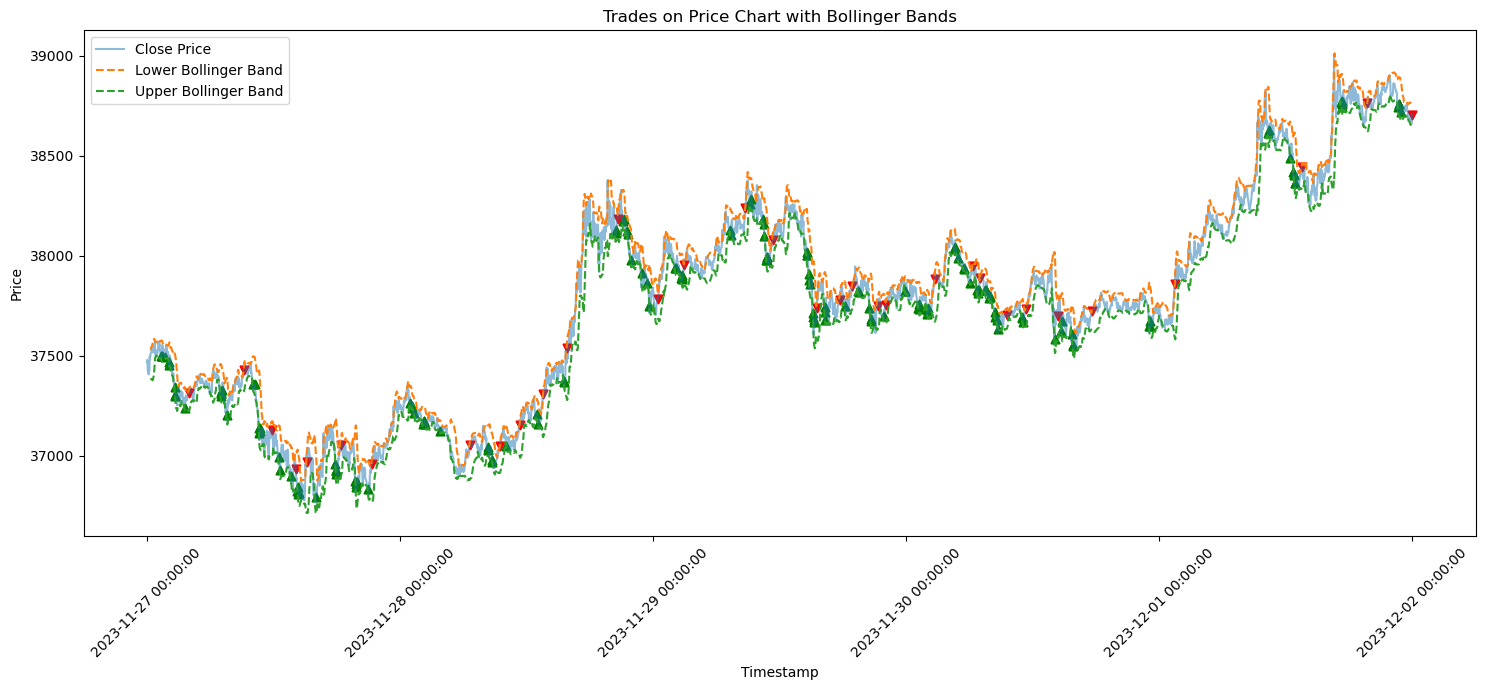

Total Trades: 202.0
Winning Trades: 66
Losing Trades: 65
Win Rate: 0.33
Accuracy: 0.50
Ending Account Balance: 100237.57


In [31]:
from alpaca_trade_api.rest import REST, TimeFrame, TimeFrameUnit
import time
import matplotlib.dates as mdates

def forward_test(start_date, end_date):
    global prev_forecast_price, account_balance, bitcoin_held

    # Loop through each day
    for single_date in pd.date_range(start=start_date, end=end_date):
            print(f"Processing data for {single_date.strftime('%Y-%m-%d')}")

            # Ensure the date format is correct
            start_str = single_date.strftime('%Y-%m-%d')
            end_str = (single_date + pd.Timedelta(days=1)).strftime('%Y-%m-%d')

            daily_data = api.get_crypto_bars([symbol], TimeFrame.Minute, start=start_str, end=end_str).df
            
            # Calculate indicators
            rsi = calculate_rsi(daily_data['close'])
            macd, macd_signal = calculate_macd(daily_data['close'])
            lower_band, upper_band = calculate_bollinger_bands(daily_data['close'])

            for index, row in daily_data.iterrows():
                current_price = row['close']
                forecast_price = forecast_from_model(row)
                timestamp = index

                # Access the specific value of the indicators for the current timestamp
                current_rsi = rsi.loc[index]
                current_macd = macd.loc[index]
                current_macd_signal = macd_signal.loc[index]

                if forecast_price > prev_forecast_price and current_rsi < 30 and current_macd < current_macd_signal:
                    account_balance, bitcoin_held = enter_trade(current_price, forecast_price, timestamp, lower_band.loc[index], account_balance, bitcoin_held, current_rsi, current_macd, current_macd_signal)

                if forecast_price < prev_forecast_price and current_rsi > 70 and current_macd > current_macd_signal:
                    account_balance, bitcoin_held = exit_trade(current_price, forecast_price, timestamp, upper_band.loc[index], account_balance, bitcoin_held, current_rsi, current_macd, current_macd_signal)

                prev_forecast_price = forecast_price
                
    # Close any remaining open positions at the end of the testing period
    if bitcoin_held > 0:
        # Use the last available price for the final sale
        final_price = daily_data['close'].iloc[-1]
        account_balance, bitcoin_held = exit_trade(final_price, prev_forecast_price, daily_data.index[-1], upper_band.iloc[-1], account_balance, bitcoin_held, rsi.iloc[-1], macd.iloc[-1], macd_signal.iloc[-1])

    return account_balance, bitcoin_held

def forecast_from_model(data_row):
    # Convert the Series to DataFrame
    exog_data = pd.DataFrame([data_row[['open', 'high', 'low']]])

    # Forecast using the ARIMA model
    forecasted_price = model_fit.forecast(steps=1, exog=exog_data)[0]
    return forecasted_price

def plot_trades_with_bollinger_bands(df, trade_log):
    lower_band, upper_band = calculate_bollinger_bands(df['close'])

    plt.figure(figsize=(15, 7))
    plt.plot(df['close'], label='Close Price', alpha=0.5)
    plt.plot(df.index, lower_band, label='Lower Bollinger Band', linestyle='--')
    plt.plot(df.index, upper_band, label='Upper Bollinger Band', linestyle='--')

    for trade in trade_log:
        if trade['action'] == 'buy':
            plt.scatter(trade['timestamp'], trade['price'], color='green', marker='^', alpha=1)
        elif trade['action'] == 'sell':
            plt.scatter(trade['timestamp'], trade['price'], color='red', marker='v', alpha=1)

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator())
    plt.xticks(rotation=45)
    
    plt.title('Trades on Price Chart with Bollinger Bands')
    plt.xlabel('Timestamp')
    plt.ylabel('Price')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
def calculate_performance(trade_log):
    # Convert the list of dictionaries into a DataFrame
    trade_log_df = pd.DataFrame(trade_log)

    # Use shift on the DataFrame column
    trade_log_df['prev_profit_loss'] = trade_log_df['profit_loss'].shift(-1)

    # Calculate wins and losses
    wins = sum(1 for i in trade_log_df.index if trade_log_df.loc[i, 'profit_loss'] > trade_log_df.loc[i, 'prev_profit_loss'])
    losses = sum(1 for i in trade_log_df.index if trade_log_df.loc[i, 'profit_loss'] < trade_log_df.loc[i, 'prev_profit_loss'])
    total_trades = len(trade_log_df)/2

    win_rate = wins / total_trades if total_trades > 0 else 0
    accuracy = wins / (wins + losses) if wins + losses > 0 else 0
    ending_profit_loss = trade_log_df['profit_loss'].iloc[-1]

    print(f"Total Trades: {total_trades}")
    print(f"Winning Trades: {wins}")
    print(f"Losing Trades: {losses}")
    print(f"Win Rate: {win_rate:.2f}")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Ending Account Balance: {account_balance:.2f}")

# Initialize Alpaca API for Data Retrieval
ALPACA_API_KEY = 'PKUNRZ9AW4P6J6YGINMK'
ALPACA_SECRET_KEY = 'U8S4kRSbtiVZQONWKL8VEVVk2OKAIdgcaLTwrNSL'
APCA_API_BASE_URL = 'https://paper-api.alpaca.markets'

symbol = "BTC/USD"
api = REST(ALPACA_API_KEY, ALPACA_SECRET_KEY, APCA_API_BASE_URL)

# Run the forward test
forward_test(pd.Timestamp("2023-11-27"), pd.Timestamp("2023-12-01"))

# After the simulation
daily_data = api.get_crypto_bars([symbol], TimeFrame.Minute, start="2023-11-27", end="2023-12-02").df
plot_trades_with_bollinger_bands(daily_data, trade_log)  # 'daily_data' should be the DataFrame of price data used in the simulation
calculate_performance(trade_log) # Calculate performance of trades

# 11. API Order Execution

In [ ]:
import pandas as pd
import datetime
import time
from alpaca_trade_api.rest import REST, TimeFrame, TimeFrameUnit
import logging

# Alpaca API Credentials
ALPACA_API_KEY = 'PKSS3O5C45UZITEEVFSP'
ALPACA_SECRET_KEY = '59WvCArp9wcUqIRqZjpnq9GPfxub5fCbZVrgufk5'
APCA_API_BASE_URL = 'https://paper-api.alpaca.markets'

class ARIMATrader:
    def __init__(self):
        self.alpaca = REST(ALPACA_API_KEY, ALPACA_SECRET_KEY, APCA_API_BASE_URL)
        self.symbol = 'BTC/USD'
        self.qty = 1
        self.model = model_fit
        self.prev_current_price = 0
        self.prev_forecast_price = 0
        self.position = 0
        self.entry_price = 0

    def get_latest_bars(self, symbol, timeframe=TimeFrame.Minute):
        try:
            barset = self.alpaca.get_crypto_bars([symbol], timeframe).df
            return barset
        except Exception as e:
            logging.error(f"Error fetching bars: {e}")
            return pd.DataFrame()

    def run(self):
        while True:
            try:
                latest_bars = self.get_latest_bars(self.symbol)
                current_price = latest_bars['close'].iloc[-1]
                forecast_price = self.model.forecast(steps=1, exog=latest_bars[['open', 'high', 'low']].iloc[-1].values)[0]
                if current_price != self.prev_current_price:
                    print("Current Price: ", round(current_price, 2))
                    print("Forecast Price: ", round(forecast_price, 2))
                    
                self.prev_current_price = current_price

                if (forecast_price > self.prev_forecast_price) and self.position == 0:
                    print("Buy to Open 1 BTC")
                    self.alpaca.submit_order(symbol=self.symbol, qty=self.qty, side='buy', type='market', time_in_force='gtc')
                    self.position = self.position + 1
                    self.entry_price = current_price
                elif (forecast_price < self.prev_forecast_price) and self.position > 0:
                    print("Sell to Close 1 BTC")
                    bitcoin_to_sell = round(current_price/self.entry_price*.997, 9)
                    self.alpaca.submit_order(symbol=self.symbol, qty=bitcoin_to_sell, side='sell', type='market', time_in_force='gtc')
                    self.position = self.position - 1

                self.prev_forecast_price = forecast_price
                time.sleep(60)  # Delay for 1 minute

            except Exception as e:
                print(f"An error occurred: {e}")

# Run the trading script
logging.basicConfig(level=logging.INFO)
trader = ARIMATrader()
trader.run()